<a href="https://colab.research.google.com/github/SalFierro83/SalFierro83/blob/main/Gym_Churn_Project_Dec25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ROC-AUC: 0.726 | Acc@0.5: 0.728 | Acc@0.21: 0.587

Classification report @ 0.5:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1965
           1       0.39      0.46      0.42       535

    accuracy                           0.73      2500
   macro avg       0.62      0.63      0.62      2500
weighted avg       0.75      0.73      0.74      2500


Tuned threshold to reach recall≈80%: 0.21

Classification report @ tuned:
               precision    recall  f1-score   support

           0       0.91      0.53      0.67      1965
           1       0.32      0.80      0.45       535

    accuracy                           0.59      2500
   macro avg       0.61      0.67      0.56      2500
weighted avg       0.78      0.59      0.62      2500



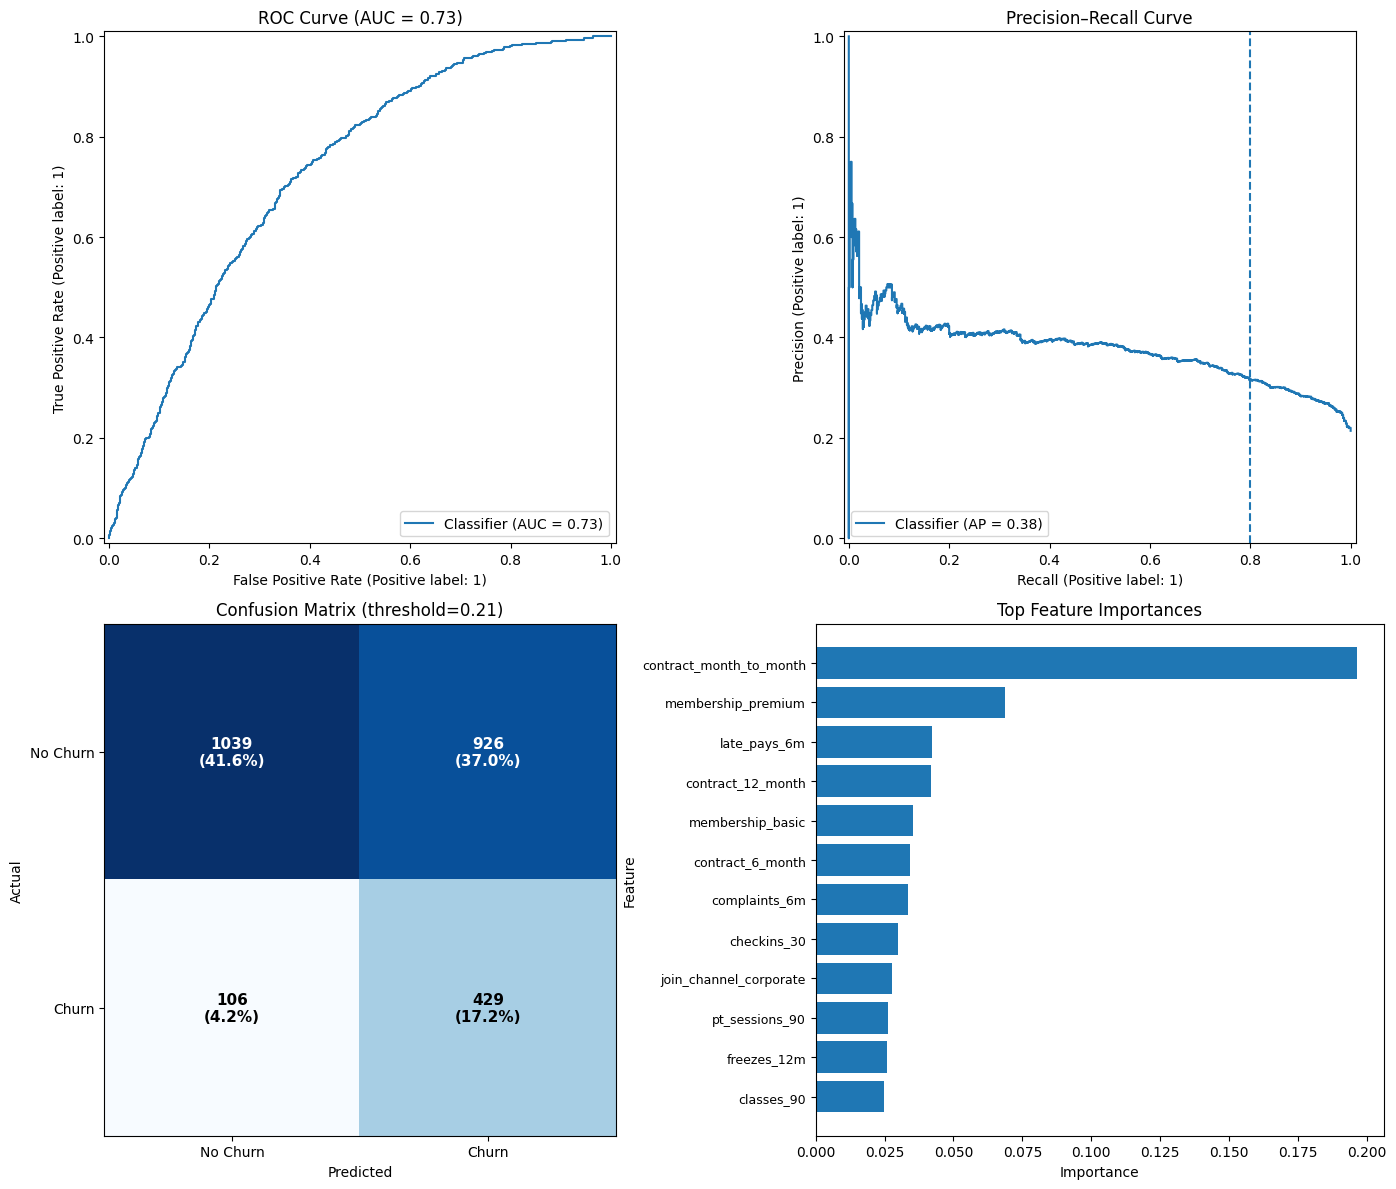


Saved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv


In [1]:
# Gym Membership Churn Prediction — Improved Version
# - Stronger signal in the synthetic data (clear churn drivers)
# - Lower noise so patterns are learnable
# - Class-imbalance handling (scale_pos_weight)
# - Threshold tuning to hit a target recall (catch churners)
# - 2x2 dashboard: ROC, PR, Confusion Matrix, Feature Importances
# - Exports PNG and CSV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, accuracy_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve,
    classification_report
)
from sklearn.impute import SimpleImputer

# Try XGBoost; fallback to sklearn boosting
try:
    from xgboost import XGBClassifier
    USE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    USE_XGB = False

# ---------------------------------------------------------------------
# 1) SYNTHETIC GYM DATASET (realistic, with stronger signals)
# ---------------------------------------------------------------------
rng = np.random.default_rng(2025)
N = 10000

age = rng.integers(16, 80, size=N)
gender = rng.choice(["M","F","Other"], size=N, p=[0.48, 0.50, 0.02])
tenure_m = rng.integers(1, 72, size=N)

contract = rng.choice(["month_to_month","6_month","12_month"], size=N, p=[0.55, 0.2, 0.25])
membership = rng.choice(["basic","standard","premium"], size=N, p=[0.45, 0.4, 0.15])
join_channel = rng.choice(["walk_in","online","referral","corporate"], size=N, p=[0.45,0.35,0.1,0.1])

base_price = ((membership=="basic")*29 + (membership=="standard")*49 + (membership=="premium")*79).astype(float)
discount = rng.choice([0,5,10,15,20], size=N, p=[0.55,0.15,0.15,0.1,0.05])
price_paid = np.maximum(15, base_price - discount + rng.normal(0,2,size=N))

distance_km = rng.gamma(2.0, 2.0, size=N)  # skewed right
app_logins_30 = rng.poisson(8, size=N)
checkins_30 = np.clip(rng.normal(10, 6, size=N).round().astype(int), 0, 40)
checkins_90 = np.clip(checkins_30 + rng.normal(18, 10, size=N), 0, 120)
classes_90 = np.clip(rng.poisson(6, size=N) + (membership=="premium")*6, 0, None)
pt_sessions_90 = np.clip(rng.poisson(1, size=N) + (membership=="premium")*1 + (membership=="standard")*0.3, 0, None)

uses_pool    = rng.choice([0,1], size=N, p=[0.7,0.3])
uses_weights = rng.choice([0,1], size=N, p=[0.2,0.8])
uses_classes = (classes_90 > 0).astype(int)

freezes_12m = rng.poisson(0.2, size=N) + (contract=="month_to_month")*rng.poisson(0.1, size=N)
late_pays_6m = rng.poisson(0.15, size=N)
complaints_6m = rng.poisson(0.1, size=N)

locker_rental = rng.choice([0,1], size=N, p=[0.85,0.15])
referral = (join_channel=="referral").astype(int)
family_addon = rng.choice([0,1], size=N, p=[0.9,0.1])

trend_delta = np.clip(checkins_30 - (checkins_90/3), -20, 20)  # recent minus 3-month avg

# >>> Stronger, clearer churn signals; reduced noise <<<
risk = (
    + 2.8*(contract=="month_to_month").astype(float)
    + 2.2*(tenure_m < 3)
    + 1.9*(trend_delta < -4)
    + 1.7*(checkins_30 < 3)
    + 1.4*(late_pays_6m > 0)
    + 1.2*(freezes_12m >= 2)
    + 1.0*(complaints_6m > 0)
    + 0.9*(distance_km > 7)

    - 1.6*(pt_sessions_90 > 0)
    - 1.3*(classes_90 > 3)
    - 1.0*(app_logins_30 > 8)
    - 1.4*(membership=="premium")

    + rng.normal(0, 0.2, size=N)  # lower noise
)

p = 1/(1+np.exp(-risk))
churn = (rng.uniform(0,1,size=N) < p*0.5).astype(int)  # ~20–30% churn

df = pd.DataFrame({
    "age":age, "gender":gender, "tenure_m":tenure_m,
    "contract":contract, "membership":membership, "join_channel":join_channel,
    "price_paid":price_paid.round(2), "discount":discount,
    "distance_km":distance_km.round(2),
    "app_logins_30":app_logins_30, "checkins_30":checkins_30, "checkins_90":checkins_90.astype(int),
    "classes_90":classes_90.astype(int), "pt_sessions_90":pt_sessions_90.astype(int),
    "uses_pool":uses_pool, "uses_weights":uses_weights, "uses_classes":uses_classes,
    "freezes_12m":freezes_12m, "late_pays_6m":late_pays_6m, "complaints_6m":complaints_6m,
    "locker_rental":locker_rental, "referral":referral, "family_addon":family_addon,
    "trend_delta":trend_delta, "churn":churn
})

# sprinkle realistic missing values
for col in ["price_paid","join_channel","checkins_30"]:
    m = rng.choice([True,False], size=N, p=[0.01,0.99])
    df.loc[m, col] = np.nan

# ---------------------------------------------------------------------
# 2) SPLIT + PREPROCESS
# ---------------------------------------------------------------------
X = df.drop(columns=["churn"])
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocess = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols)
])

# ---------------------------------------------------------------------
# 3) MODEL (imbalance aware) + TRAIN
# ---------------------------------------------------------------------
pos_rate = y_train.mean()
neg_rate = 1 - pos_rate
scale_pos_weight = float(neg_rate / pos_rate)

if USE_XGB:
    model = XGBClassifier(
        n_estimators=600, learning_rate=0.08, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        min_child_weight=3, gamma=0.0, tree_method="hist",
        eval_metric="logloss", random_state=42,
        scale_pos_weight=scale_pos_weight
    )
else:
    from sklearn.ensemble import HistGradientBoostingClassifier
    model = HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.1, max_iter=450, random_state=42
    )

pipe = Pipeline([("prep", preprocess), ("model", model)])
pipe.fit(X_train, y_train)

# ---------------------------------------------------------------------
# 4) METRICS + THRESHOLD TUNING
# ---------------------------------------------------------------------
if hasattr(model, "predict_proba"):
    y_proba = pipe.predict_proba(X_test)[:,1]
else:
    s = pipe.decision_function(X_test)
    y_proba = 1/(1+np.exp(-s))

# Default 0.5
y_pred_05 = (y_proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)
auc = roc_auc_score(y_test, y_proba)
acc_05 = accuracy_score(y_test, y_pred_05)

# Tune threshold to hit recall target (catch more churners)
prec, rec, th = precision_recall_curve(y_test, y_proba)
target_recall = 0.80
try:
    idx = np.where(rec >= target_recall)[0][-1]
    tuned_thr = th[max(idx-1, 0)]
except Exception:
    tuned_thr = 0.4  # safe fallback

y_pred_tuned = (y_proba >= tuned_thr).astype(int)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
acc_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"ROC-AUC: {auc:.3f} | Acc@0.5: {acc_05:.3f} | Acc@{tuned_thr:.2f}: {acc_tuned:.3f}")
print("\nClassification report @ 0.5:\n", classification_report(y_test, y_pred_05))
print(f"\nTuned threshold to reach recall≈{target_recall:.0%}: {tuned_thr:.2f}")
print("\nClassification report @ tuned:\n", classification_report(y_test, y_pred_tuned))

# ---------------------------------------------------------------------
# 5) PLOTTING HELPERS
# ---------------------------------------------------------------------
def plot_confusion_matrix(cm, ax=None, class_names=("No Churn","Churn")):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    cm_percent = cm / cm.sum() * 100
    vmin, vmax = im.get_clim()
    thr = (vmin + vmax) / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i,j]; pct = cm_percent[i,j]
            color = "white" if im.get_array()[i,j] > thr else "black"
            ax.text(j,i,f"{val}\n({pct:.1f}%)",ha="center",va="center",
                    color=color,fontsize=11,fontweight="bold")
    return ax

def get_feature_importances(pipe, cat_cols, num_cols):
    ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    feature_names = list(ohe.get_feature_names_out(cat_cols)) + num_cols
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature":feature_names,"importance":importances})
    return fi.sort_values("importance", ascending=False)

# ---------------------------------------------------------------------
# 6) 2×2 DASHBOARD (ROC, PR, ConfMat @ tuned, Feature Importances)
# ---------------------------------------------------------------------
fi = get_feature_importances(pipe, cat_cols, num_cols).head(12)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# ROC
RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0,0])
axes[0,0].set_title(f"ROC Curve (AUC = {auc:.2f})")

# Precision–Recall (+ vertical line at target recall)
PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[0,1])
axes[0,1].axvline(x=target_recall, linestyle="--")
axes[0,1].set_title("Precision–Recall Curve")

# Confusion Matrix at tuned threshold
plot_confusion_matrix(cm_tuned, ax=axes[1,0], class_names=("No Churn","Churn"))
axes[1,0].set_title(f"Confusion Matrix (threshold={tuned_thr:.2f})")

# Feature Importances
axes[1,1].barh(fi["feature"][::-1], fi["importance"][::-1])
axes[1,1].set_title("Top Feature Importances")
axes[1,1].set_xlabel("Importance")
axes[1,1].set_ylabel("Feature")
axes[1,1].tick_params(axis='y', labelsize=9)

plt.tight_layout()
os.makedirs("charts", exist_ok=True)
plt.savefig("charts/gym_churn_dashboard.png", dpi=300)
plt.show()

# ---------------------------------------------------------------------
# 7) SAVE DATASET
# ---------------------------------------------------------------------
df.to_csv("gym_membership_dataset.csv", index=False)
print("\nSaved: charts/gym_churn_dashboard.png and gym_membership_dataset.csv")